# Import Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load and Inspect Data

In [23]:
df = pd.read_csv('../data/telco_customer_churn.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [24]:
print(df.head(5))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

# Data Cleaning

In [25]:
# Convert TotalCharges to numeric, fill missing with median
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
# Drop customerID (not useful for modeling)
df.drop('customerID', axis=1, inplace=True)
# Check for duplicates
df.drop_duplicates(inplace=True)
# Verify no missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


# Exploratory Data Analysis

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7021.000000  7021.000000     7021.000000   7021.000000
mean        0.162512    32.469449       64.851894   2288.954490
std         0.368947    24.534965       30.069001   2265.319449
min         0.000000     0.000000       18.250000     18.800000
25%         0.000000     9.000000       35.750000    411.150000
50%         0.000000    29.000000       70.400000   1400.550000
75%         0.000000    55.000000       89.900000   3801.700000
max         1.000000    72.000000      118.750000   8684.800000


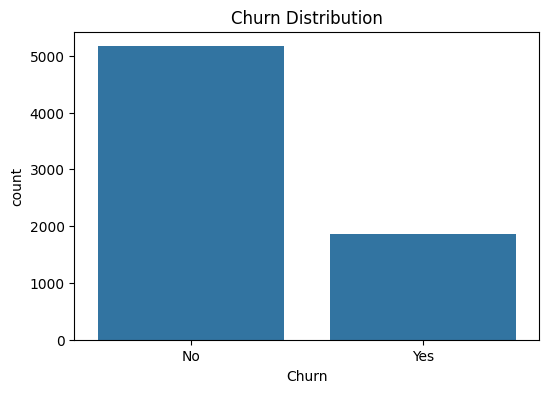

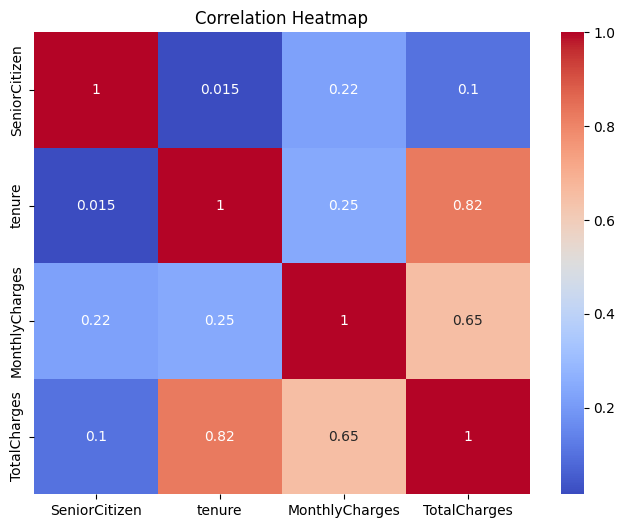

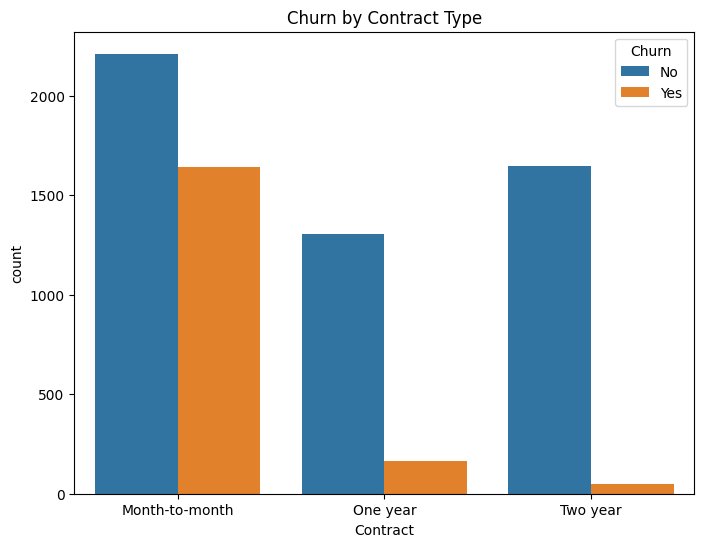

In [26]:
# Summary statistics
print(df.describe())
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.savefig('churn_distribution.png')
plt.show()
# Correlation heatmap for numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()
# Churn by contract type
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.savefig('churn_by_contract.png')
plt.show()

# Feature Engineering

In [27]:
# Create new feature: AvgMonthlyCharge
df['AvgMonthlyCharge'] = df['TotalCharges'] / (df['tenure'] + 1)  # Add 1 to avoid division by zero
# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns.drop('Churn')
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
# Scale numerical features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge']
df[num_cols] = scaler.fit_transform(df[num_cols])
# Save scaler for Streamlit app
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Modeling and Evaluation

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1053
           1       0.61      0.50      0.55       352

    accuracy                           0.80      1405
   macro avg       0.73      0.70      0.71      1405
weighted avg       0.79      0.80      0.79      1405

ROC-AUC: 0.8454847621514289
Random Forest Results:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1053
           1       0.59      0.49      0.54       352

    accuracy                           0.79      1405
   macro avg       0.71      0.69      0.70      1405
weighted avg       0.78      0.79      0.78      1405

ROC-AUC: 0.8263740503323836
XGBoost Results:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1053
           1       0.61      0.53      0.57       352

    accuracy                           0.80      1405
   

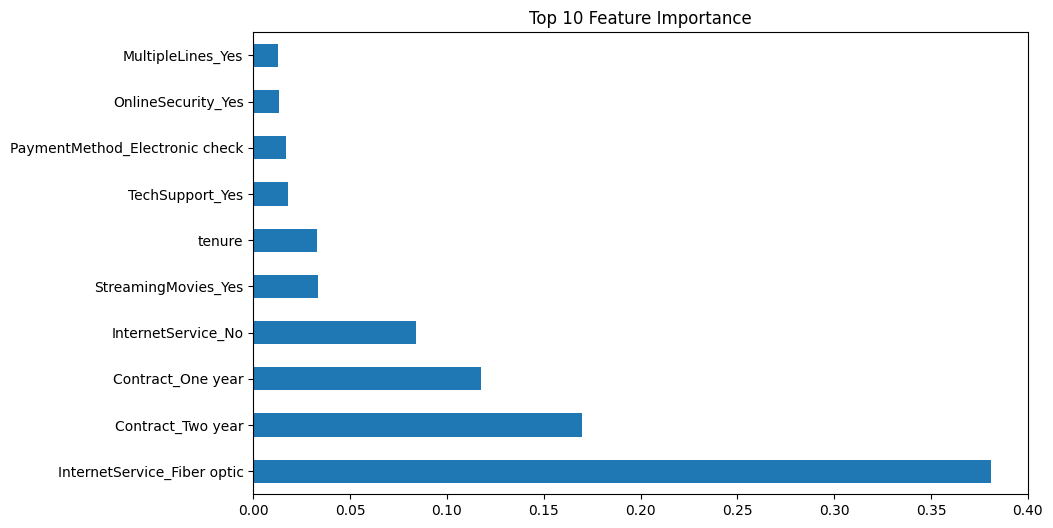

In [28]:
# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Logistic Regression (Baseline)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
# XGBoost with GridSearchCV
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
y_pred_xgb = grid.predict(X_test)
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("Best Parameters:", grid.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1]))
# Save best model
joblib.dump(grid.best_estimator_, 'churn_model.pkl')
# Feature importance
feat_importance = pd.Series(grid.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feat_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importance')
plt.savefig('feature_importance.png')
plt.show()